In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import joblib
from transformers import LongformerForSequenceClassification, LongformerTokenizer

# Rutas a los archivos guardados
model_path = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Long/long_model'
tokenizer_path = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Long/long_tokenizer'

# Cargar el modelo entrenado
model = LongformerForSequenceClassification.from_pretrained(model_path)

# Cargar el tokenizador
tokenizer = LongformerTokenizer.from_pretrained(tokenizer_path)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv to MEDIQA-CORR-2024-MS-ValidationSet-1-Full (1).csv


In [5]:
df = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv', delimiter=',', encoding='utf-8')
# df= df.drop(['Error Sentence ID', 'Error Sentence', 'Corrected Sentence', 'Corrected Text'], axis=1)
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
0,0,ms-val-0,A 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,1,5,Culture tests indicate Neisseria gonorrhoeae.,Culture tests indicate Trichomonas vaginalis.,A 24-year-old woman comes to the emergency dep...
1,1,ms-val-1,A 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,0,-1,NaN,NaN,NaN
2,2,ms-val-2,A 43-year-old woman comes to the physician bec...,0 A 43-year-old woman comes to the physician b...,1,24,Pathology confirms Streptococcus pneumoniae is...,Pathology confirms Mycoplasma pneumoniae is th...,A 43-year-old woman comes to the physician bec...
3,3,ms-val-3,A 4-year-old is brought into the emeregency ro...,0 A 4-year-old is brought into the emeregency ...,1,4,Laboratory studies confirm that he has a respi...,Laboratory studies confirm that he has parainf...,A 4-year-old is brought into the emeregency ro...
4,4,ms-val-4,A previously healthy 25-year-old man comes to ...,0 A previously healthy 25-year-old man comes t...,1,0,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...


In [6]:
# Analizamos las primeras 5 columnas para obtener sus tipos de datos y otras características
column_info = df.dtypes

# Analizamos los nombres de las columnas para identificar las primeras 5
column_names = df.columns[:5]

# Extraemos ejemplos de datos de las primeras 5 columnas para entender mejor su contenido
sample_data = df.head()

column_info[:5], column_names, sample_data

(Unnamed: 0     int64
 Text ID       object
 Text          object
 Sentences     object
 Error Flag     int64
 dtype: object,
 Index(['Unnamed: 0', 'Text ID', 'Text', 'Sentences', 'Error Flag'], dtype='object'),
    Unnamed: 0   Text ID                                               Text  \
 0           0  ms-val-0  A 24-year-old woman comes to the emergency dep...   
 1           1  ms-val-1  A 24-year-old woman comes to the emergency dep...   
 2           2  ms-val-2  A 43-year-old woman comes to the physician bec...   
 3           3  ms-val-3  A 4-year-old is brought into the emeregency ro...   
 4           4  ms-val-4  A previously healthy 25-year-old man comes to ...   
 
                                            Sentences  Error Flag  \
 0  0 A 24-year-old woman comes to the emergency d...           1   
 1  0 A 24-year-old woman comes to the emergency d...           0   
 2  0 A 43-year-old woman comes to the physician b...           1   
 3  0 A 4-year-old is brought into t

In [7]:
# Revisar los valores nulos
df.replace('', np.nan, inplace=True)

# Lista de columnas a revisar
columns_to_check = ['Unnamed: 0', 'Text ID', 'Text', 'Sentences', 'Error Flag']

#  Iterar sobre cada columna y contar los valores nulos
for column in columns_to_check:
    # Contar los valores nulos en la columna
    missing_count = df[column].isnull().sum()
    print(f'Número de datos faltantes en {column}: {missing_count}')


Número de datos faltantes en Unnamed: 0: 0
Número de datos faltantes en Text ID: 0
Número de datos faltantes en Text: 0
Número de datos faltantes en Sentences: 0
Número de datos faltantes en Error Flag: 0


In [8]:
import re

special_char_pattern = re.compile(r'[^a-zA-Z0-9 \.,!?]')

# Re-definir la lista de columnas a revisar para caracteres especiales
columns_to_check = ['Text ID', 'Text', 'Sentences']

# Contar los caracteres especiales en las columnas de texto seleccionadas
special_characters_counts = df[columns_to_check].applymap(lambda x: len(special_char_pattern.findall(x)) if pd.notnull(x) else 0)

# Calcular el total de caracteres especiales por columna
total_special_characters_per_column = special_characters_counts.sum()

total_special_characters_per_column


Text ID       1148
Text          6573
Sentences    19822
dtype: int64

In [9]:
from collections import Counter

# Extraer todos los caracteres especiales encontrados en la columna 'Text'
all_special_characters_text_id = ''.join(df['Text'].apply(lambda x: ''.join(special_char_pattern.findall(x))))

# Contar la frecuencia de cada caracter especial
special_character_frequencies_text_id = Counter(all_special_characters_text_id)

special_character_frequencies_text_id


Counter({'-': 1944,
         "'": 154,
         '/': 1473,
         '(': 451,
         ')': 451,
         ':': 230,
         '\n': 864,
         '+': 117,
         ';': 93,
         'â': 171,
         '‰': 4,
         '¥': 4,
         'Î': 22,
         '¼': 16,
         '=': 18,
         '€': 159,
         '“': 67,
         '%': 163,
         '^': 15,
         '>': 5,
         'œ': 39,
         '\x9d': 39,
         'Ë': 2,
         'š': 2,
         '<': 16,
         '"': 6,
         '™': 14,
         '±': 6,
         'Ã': 6,
         '©': 1,
         'ˆ': 8,
         '’': 8,
         'Ÿ': 5})

In [10]:
# Inspeccionar los caracteres especiales más frecuentes en 'Text' y 'Sentences'
def extract_special_characters(text):
    return special_char_pattern.findall(text)

# Aplicar la extracción a las columnas 'Text' y 'Sentences'
special_characters_text = ''.join(df['Text'].apply(lambda x: ''.join(extract_special_characters(x))))
special_characters_sentences = ''.join(df['Sentences'].apply(lambda x: ''.join(extract_special_characters(x))))

# Contar la frecuencia de cada caracter especial
special_character_frequencies_text = Counter(special_characters_text)
special_character_frequencies_sentences = Counter(special_characters_sentences)

# Identificar los 10 caracteres especiales más comunes en cada columna
top_10_special_characters_text = special_character_frequencies_text.most_common(10)
top_10_special_characters_sentences = special_character_frequencies_sentences.most_common(10)

top_10_special_characters_text, top_10_special_characters_sentences

([('-', 1944),
  ('/', 1473),
  ('\n', 864),
  ('(', 451),
  (')', 451),
  (':', 230),
  ('â', 171),
  ('%', 163),
  ('€', 159),
  ("'", 154)],
 [('\n', 11589),
  ('-', 2822),
  ('/', 2125),
  ('(', 654),
  (')', 654),
  (':', 321),
  ('â', 245),
  ('%', 231),
  ('€', 227),
  ("'", 218)])

In [11]:
from collections import defaultdict
import re

text_column = df['Text']

# Definir un patrón de regex para buscar caracteres que no sean alfanuméricos ni espacios básicos
special_char_pattern = re.compile(r'[^a-zA-Z0-9\s]')

# Diccionario para almacenar hasta 5 ejemplos por cada carácter especial encontrado
examples_per_special_char = defaultdict(list)

# Recorrer cada texto en la columna 'Text'
for text in text_column:
    # Encontrar todos los caracteres especiales únicos en el texto actual
    unique_special_chars = set(special_char_pattern.findall(text))
    # Para cada carácter especial encontrado, agregar el texto actual como un ejemplo
    for char in unique_special_chars:
        if len(examples_per_special_char[char]) < 10:
            examples_per_special_char[char].append(text)

# Convertir el diccionario a un formato más legible para la presentación
{char: examples[:2] for char, examples in examples_per_special_char.items()}

{'/': ["A 24-year-old woman comes to the emergency department because of a 4-hour history of headaches, nausea, and vomiting. During this time, she has also had recurrent dizziness and palpitations. The symptoms started while she was at a friend's birthday party, where she had one beer. One week ago, the patient was diagnosed with a genitourinary infection and started on antimicrobial therapy. She has no history of major medical illness. Culture tests indicate Neisseria gonorrhoeae. Her pulse is 106/min and blood pressure is 102/73 mm Hg. Physical examination shows facial flushing and profuse sweating. ",
  "A 24-year-old woman comes to the emergency department because of a 4-hour history of headaches, nausea, and vomiting. During this time, she has also had recurrent dizziness and palpitations. The symptoms started while she was at a friend's birthday party, where she had one beer. One week ago, the patient was diagnosed with a genitourinary infection and started on antimicrobial ther

In [12]:
# Reemplazar caracteres especiales por su equivalente en texto
replacements = {
    "â€\x9d": " ",
    ".â€\x9d": ".",
    "â€“": "-",
    "â€œsomething": "something",
    "patientâ€™s": "patients",
    "â‰¥": "≥",
    "\n": ",",
    "â€œ": "",
    "Waldenstromâ€™s": "Waldenströms",
    "Âµmol/L": "µmol/L",
    "â€œmemory": "memory",
    "weeksâ€™": "weeks",
    "74 Î¼m3": "74 μm^3",
    "ÂµIU/L": "µIU/L",
    "â‰¤": "≤",
    "Clâˆ’": "Cl-",
    "physicianâ€™s": "physicians",
    "ÂºF": "ºF",
    "âˆ’": "-",
    "Â½": "½",
    "Î¼g/dL": "μg/dL",
    "pediatricianâ€™s": "pediatricians",
    "yearsâ€™": "years",
    "Âµg": "µg",
    "â€": "",
    "Kennedyâ€™s": "Kennedys",
    "Kennedy™s": "Kennedys",
    "can™t": "can't",
    "Î²": "β",
    "Ã—": "x",
    "ÃŸ-hCG": "β-hCG",
    "SÃ©quard": "Séquard",
    "Î³": "γ",
    "Î¼m3": "μm^3",
    "Î±": "α",
    "Î¼U/mL": "μU/mL",
    "Î¼": "μ",
    "'": " ",
    "\"":"" #Este lo dejo a consideracion, dependiendo si les funciona o no
}

# Aplicar todas las sustituciones
for old, new in replacements.items():
    df['Text'] = df['Text'].str.replace(old, new, regex=False)

# Verificar el reemplazo
df['Text'].head()


0    A 24-year-old woman comes to the emergency dep...
1    A 24-year-old woman comes to the emergency dep...
2    A 43-year-old woman comes to the physician bec...
3    A 4-year-old is brought into the emeregency ro...
4    A previously healthy 25-year-old man comes to ...
Name: Text, dtype: object

In [13]:
import pandas as pd
import re

# Suponiendo que df es tu DataFrame

# Función para aplicar todas las transformaciones no regex en una sola pasada
def optimize_text(text):
    # Aplicar transformaciones no regex
    text = text.strip().replace("Cl- ", "Cl ").replace("'", "").replace("’", "")
    text = text.replace(":,", ":").replace(',_', ',').replace('[', '').replace(']', '')
    text = text.replace(';', ',').replace('.,', '.').replace('mg dl', 'mg/dl')
    text = text.replace('é', 'e').replace('patient s', 'patients').replace('girl s', 'girls')
    text = text.replace('gilbert s', 'gilberts').replace(".'", ".").replace(",'", ",")
    text = text.replace("',", ",").lower()  # Convertir a minúsculas aquí para optimizar
    return text

# Aplicar optimizaciones no regex
df['Text'] = df['Text'].apply(optimize_text)

# Aplicar optimizaciones con regex
df['Text'] = df['Text'].str.replace(r',,', ',', regex=True)
df['Text'] = df['Text'].str.replace(r'  +', ' ', regex=True)
df['Text'] = df['Text'].str.replace('mm hg', 'mmHg', flags=re.IGNORECASE, regex=True)

In [14]:
print(df['Text'])

0      a 24-year-old woman comes to the emergency dep...
1      a 24-year-old woman comes to the emergency dep...
2      a 43-year-old woman comes to the physician bec...
3      a 4-year-old is brought into the emeregency ro...
4      a previously healthy 25-year-old man comes to ...
                             ...                        
569    a 20-year-old woman presents to the emergency ...
570    a 20-year-old woman presents to the emergency ...
571    a 26-year-old male comes into your clinic comp...
572    a 56-year-old woman with a history of alcoholi...
573    a 56-year-old woman with a history of alcoholi...
Name: Text, Length: 574, dtype: object


In [15]:
#Esto lo hago con el fin de validar que no haya caracteres especiales, estre codigo va antes y despues de la limpieza de caracteres especiales, con el fin de validar que tenia y que limpio

text_column = df['Text']

# Definir un patrón de regex para buscar caracteres que no sean alfanuméricos ni espacios básicos
special_char_pattern = re.compile(r'[^a-zA-Z0-9\s]')

# Diccionario para almacenar hasta 5 ejemplos por cada carácter especial encontrado
examples_per_special_char = defaultdict(list)

# Recorrer cada texto en la columna 'Text'
for text in text_column:
    # Encontrar todos los caracteres especiales únicos en el texto actual
    unique_special_chars = set(special_char_pattern.findall(text))
    # Para cada carácter especial encontrado, agregar el texto actual como un ejemplo
    for char in unique_special_chars:
        if len(examples_per_special_char[char]) < 1:
            examples_per_special_char[char].append(text)

# Convertir el diccionario a un formato más legible para la presentación
{char: examples[:2] for char, examples in examples_per_special_char.items()}
examples_per_special_char

defaultdict(list,
            {'/': ['a 24-year-old woman comes to the emergency department because of a 4-hour history of headaches, nausea, and vomiting. during this time, she has also had recurrent dizziness and palpitations. the symptoms started while she was at a friend s birthday party, where she had one beer. one week ago, the patient was diagnosed with a genitourinary infection and started on antimicrobial therapy. she has no history of major medical illness. culture tests indicate neisseria gonorrhoeae. her pulse is 106/min and blood pressure is 102/73 mmHg. physical examination shows facial flushing and profuse sweating.'],
             '-': ['a 24-year-old woman comes to the emergency department because of a 4-hour history of headaches, nausea, and vomiting. during this time, she has also had recurrent dizziness and palpitations. the symptoms started while she was at a friend s birthday party, where she had one beer. one week ago, the patient was diagnosed with a genitourina

In [16]:
# Inspeccionar los caracteres especiales más frecuentes en 'Text' y 'Sentences'
# Reviso nuevamente los 10 mas comunes, comparandolo con sentences y ver que resultados obtengo
def extract_special_characters(text):
    return special_char_pattern.findall(text)

# Aplicar la extracción a las columnas 'Text' y 'Sentences'
special_characters_text = ''.join(df['Text'].apply(lambda x: ''.join(extract_special_characters(x))))
special_characters_sentences = ''.join(df['Sentences'].apply(lambda x: ''.join(extract_special_characters(x))))

# Contar la frecuencia de cada caracter especial
special_character_frequencies_text = Counter(special_characters_text)
special_character_frequencies_sentences = Counter(special_characters_sentences)

# Identificar los 10 caracteres especiales más comunes en cada columna
top_10_special_characters_text = special_character_frequencies_text.most_common(10)
top_10_special_characters_sentences = special_character_frequencies_sentences.most_common(10)

top_10_special_characters_text, top_10_special_characters_sentences

([('.', 6464),
  (',', 3704),
  ('-', 1999),
  ('/', 1473),
  ('(', 451),
  (')', 451),
  (':', 230),
  ('%', 163),
  ('+', 117),
  ('^', 22)],
 [('.', 9335),
  (',', 4117),
  ('-', 2822),
  ('/', 2125),
  ('(', 654),
  (')', 654),
  (':', 321),
  ('â', 245),
  ('%', 231),
  ('€', 227)])

In [17]:
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
0,0,ms-val-0,a 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,1,5,Culture tests indicate Neisseria gonorrhoeae.,Culture tests indicate Trichomonas vaginalis.,A 24-year-old woman comes to the emergency dep...
1,1,ms-val-1,a 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,0,-1,NaN,NaN,NaN
2,2,ms-val-2,a 43-year-old woman comes to the physician bec...,0 A 43-year-old woman comes to the physician b...,1,24,Pathology confirms Streptococcus pneumoniae is...,Pathology confirms Mycoplasma pneumoniae is th...,A 43-year-old woman comes to the physician bec...
3,3,ms-val-3,a 4-year-old is brought into the emeregency ro...,0 A 4-year-old is brought into the emeregency ...,1,4,Laboratory studies confirm that he has a respi...,Laboratory studies confirm that he has parainf...,A 4-year-old is brought into the emeregency ro...
4,4,ms-val-4,a previously healthy 25-year-old man comes to ...,0 A previously healthy 25-year-old man comes t...,1,0,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...


In [18]:
# Estadísticas para 'Unnamed: 0' (siendo numérica, pero solo representa un índice)
unnamed_stats = df['Unnamed: 0'].describe()
unnamed_stats

count    574.000000
mean     286.500000
std      165.843802
min        0.000000
25%      143.250000
50%      286.500000
75%      429.750000
max      573.000000
Name: Unnamed: 0, dtype: float64

In [19]:
# Estadísticas para 'Text ID' (resumen categórico)
text_id_stats = df['Text ID'].describe()
text_id_stats


count          574
unique         574
top       ms-val-0
freq             1
Name: Text ID, dtype: object

In [20]:
# Estadísticas para 'Text' (resumen categórico)
text_stats = df['Text'].describe()

text_stats


count                                                   574
unique                                                  574
top       a 24-year-old woman comes to the emergency dep...
freq                                                      1
Name: Text, dtype: object

In [21]:
# Estadísticas para 'Sentences' (resumen categórico)
sentences_stats = df['Sentences'].describe()

sentences_stats

count                                                   574
unique                                                  574
top       0 A 24-year-old woman comes to the emergency d...
freq                                                      1
Name: Sentences, dtype: object

In [22]:
# Seleccionando solo la columna 'Text' para ejemplos donde Error Flag es 1
error_flag_1_text_examples = df[df['Error Flag'] == 1]['Text'].sample(n=20, random_state=1)

# Seleccionando solo la columna 'Text' para ejemplos donde Error Flag es 0
error_flag_0_text_examples = df[df['Error Flag'] == 0]['Text'].sample(n=20, random_state=1)

# Mostrando los ejemplos
error_flag_1_text_examples, error_flag_0_text_examples


(227    a 47-year-old woman comes to the physician for...
 202    a 48-year-old woman comes to the emergency dep...
 146    a 25-year-old woman comes to the physician for...
 242    a 27-year-old woman, gravida 2, para 1, at 37 ...
 244    a 3500-g (7.7-lbs) girl is delivered at 39 wee...
 445    a 62-year-old man comes to the emergency depar...
 393    a 7-year-old boy presents with right hip pain ...
 156    a 13-year-old boy is brought to the physician ...
 305    a previously healthy 18-year-old army recruit ...
 495    a 60-year-old man with a 1-year history of rec...
 169    a 32-year-old woman with cluster headaches com...
 405    a 6-month-old male presents to the emergency d...
 108    a 3175-g (7-lb) female newborn is delivered at...
 161    a 17-year-old rugby player limped into the eme...
 518    a 52-year-old man comes to the physician becau...
 423    a 43-year-old man is brought to the emergency ...
 269    a 12-year-old boy is brought to his pediatrici...
 165    a 29-y

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

TF-IDF, que significa "Term Frequency-Inverse Document Frequency" (Frecuencia de Término - Frecuencia Inversa de Documento), es una técnica estadística utilizada para evaluar la importancia de una palabra en un documento dentro de una colección o corpus de documentos.

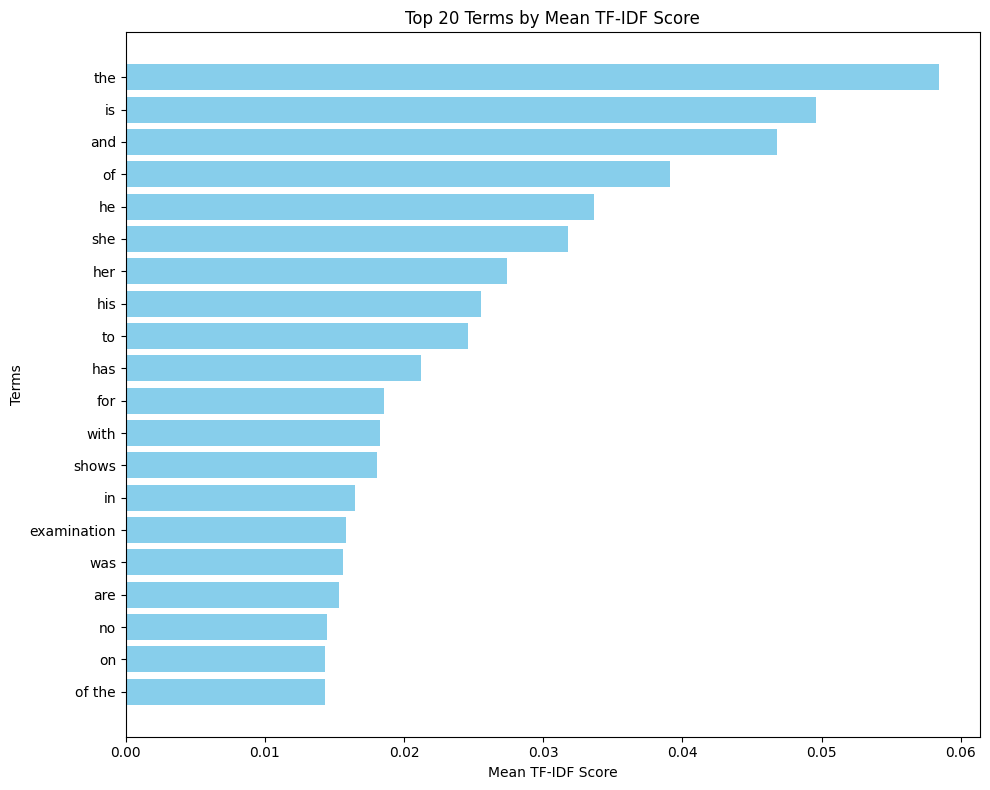

In [24]:
import numpy as np
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# Seleccionando solo los textos con errores
texts_with_errors = df[df['Error Flag'] == 1]['Text']

#
# Ajustando el vectorizador a los textos y transformándolos en una matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(texts_with_errors)

# Obteniendo los nombres de las características (términos) para su posterior análisis
feature_names = vectorizer.get_feature_names_out()

# Calculando las puntuaciones TF-IDF promedio para cada término
tfidf_means = np.mean(tfidf_matrix, axis=0)
tfidf_means = np.array(tfidf_means).flatten()

# Creando un DataFrame para los términos y sus puntuaciones TF-IDF promedio
terms_tfidf = pd.DataFrame({'Term': feature_names, 'TF-IDF': tfidf_means})

# Ordenando los términos por sus puntuaciones TF-IDF promedio, de mayor a menor
terms_tfidf_sorted = terms_tfidf.sort_values(by='TF-IDF', ascending=False).head(20)

# Graficando los 20 términos más relevantes basados en sus puntuaciones TF-IDF promedio
plt.figure(figsize=(10, 8))
plt.barh(terms_tfidf_sorted['Term'][::-1], terms_tfidf_sorted['TF-IDF'][::-1], color='skyblue')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Terms')
plt.title('Top 20 Terms by Mean TF-IDF Score')
plt.tight_layout()
plt.show()


**Bigramas (Dos Palabras Consecutivas)**

- La gráfica de bigramas revela combinaciones de dos palabras que aparecen juntas frecuentemente en textos con errores. Estos bigramas pueden representar frases técnicas específicas, entidades nombradas, o patrones lingüísticos que son comunes en textos con imprecisiones o errores específicos.
Los bigramas con mayores puntuaciones TF-IDF son aquellos que, si bien pueden aparecer en un número limitado de documentos, su presencia es muy significativa dentro de esos textos.

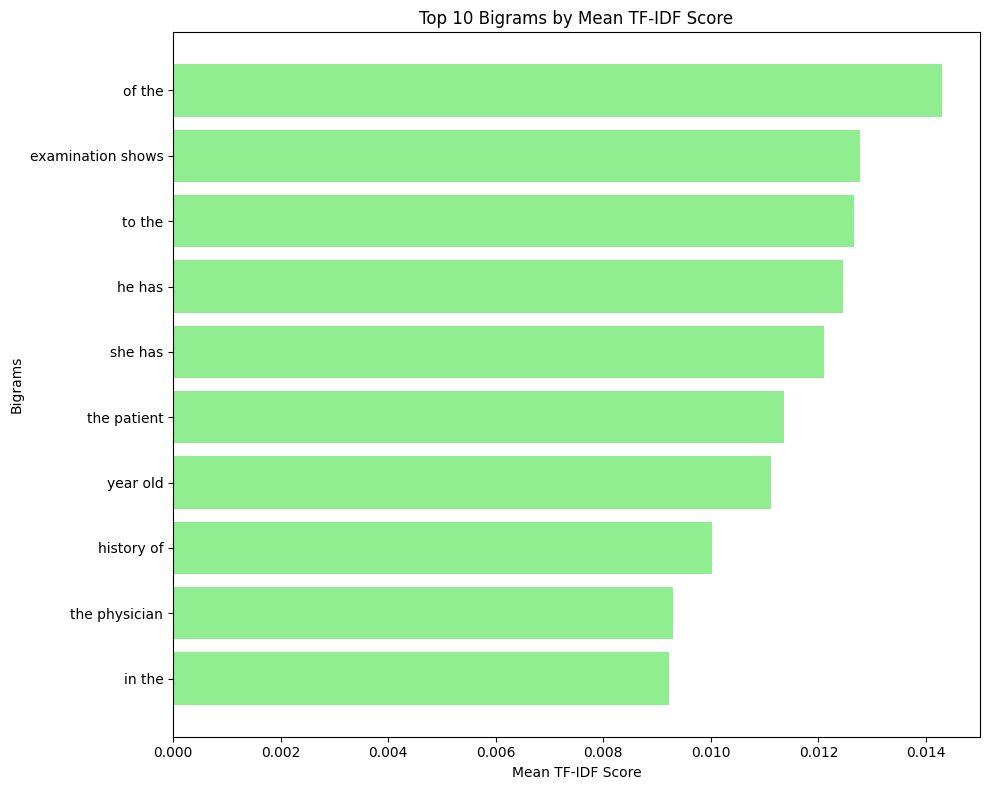

In [25]:
# bigramas
bigrams = [term for term in feature_names if len(term.split()) == 2]

# Filtrando las puntuaciones TF-IDF para bigramas y trigramas
bigrams_tfidf = terms_tfidf[terms_tfidf['Term'].isin(bigrams)].sort_values(by='TF-IDF', ascending=False).head(10)

# Gráficas para Bigramas
plt.figure(figsize=(10, 8))
plt.barh(bigrams_tfidf['Term'][::-1], bigrams_tfidf['TF-IDF'][::-1], color='lightgreen')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Bigrams')
plt.title('Top 10 Bigrams by Mean TF-IDF Score')
plt.tight_layout()
plt.show()



**Trigramas (Tres Palabras Consecutivas)**

- Similarmente, la gráfica de trigramas muestra las secuencias de tres palabras que son destacadas en el contexto de los errores. Estos trigramas pueden proporcionar aún más contexto que los bigramas, capturando frases o términos técnicos complejos que son cruciales para entender los errores específicos en el texto.
Al igual que con los bigramas, los trigramas de alta puntuación TF-IDF son especialmente relevantes para los documentos en los que aparecen, lo que indica su importancia para identificar o caracterizar los errores.

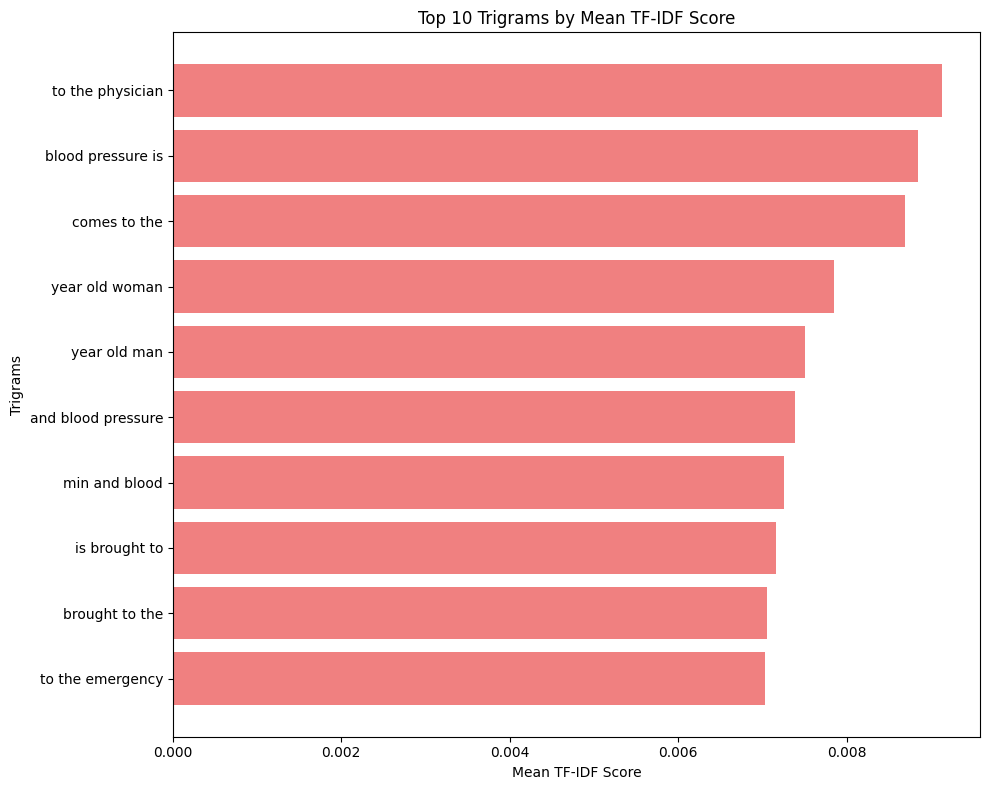

In [26]:
trigrams = [term for term in feature_names if len(term.split()) == 3]

# Filtrando las puntuaciones TF-IDF
trigrams_tfidf = terms_tfidf[terms_tfidf['Term'].isin(trigrams)].sort_values(by='TF-IDF', ascending=False).head(10)

# Gráficas para Trigramas
plt.figure(figsize=(10, 8))
plt.barh(trigrams_tfidf['Term'][::-1], trigrams_tfidf['TF-IDF'][::-1], color='lightcoral')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Trigrams')
plt.title('Top 10 Trigrams by Mean TF-IDF Score')
plt.tight_layout()
plt.show()


In [27]:
pip install torch

In [28]:
pip install transformers[torch]

In [29]:
pip install --upgrade transformers

In [30]:
pip install accelerate -U

In [31]:
pip install accelerate

In [32]:
pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-mii36ict
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-mii36ict
  Resolved https://github.com/huggingface/accelerate to commit 829171a9a496e7e1496af27a141924ac89ba0918
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [33]:
pip install scikit-learn

In [34]:
pip install -U sentence-transformers

In [35]:
pip install sentence-transformers

In [36]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [37]:
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments, Trainer
from transformers import TextDataset, DataCollatorWithPadding
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from tqdm.auto import tqdm
import torch

In [38]:
pip install tqdm


In [39]:
pip install imbalanced-learn


In [40]:
from transformers import pipeline
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

texts = df['Text'].values
labels = df['Error Flag'].values

# Preparar una pipeline para clasificación
nlp_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Procesar los textos (esto puede tomar tiempo dependiendo de la longitud de 'df')
results = nlp_pipeline(texts.tolist())

# Obtener la clase con la probabilidad más alta para cada texto
predictions = [np.argmax(result[0]['score']) for result in results]

# Convertir las predicciones a un array de numpy para calcular métricas
predictions = np.array(predictions)

# Calcular y mostrar métricas de evaluación
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Accuracy on new data: {accuracy}")
print(f"Precision on new data: {precision}")
print(f"Recall on new data: {recall}")
print(f"F1 Score on new data: {f1}")


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Initializing global attention on CLS token...
Input ids are automatically padded from 135 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 133 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 107 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 138 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 134 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 180 t

Accuracy on new data: 0.4442508710801394
Precision on new data: 0.19735883645546262
Recall on new data: 0.4442508710801394
F1 Score on new data: 0.27330270717837285


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


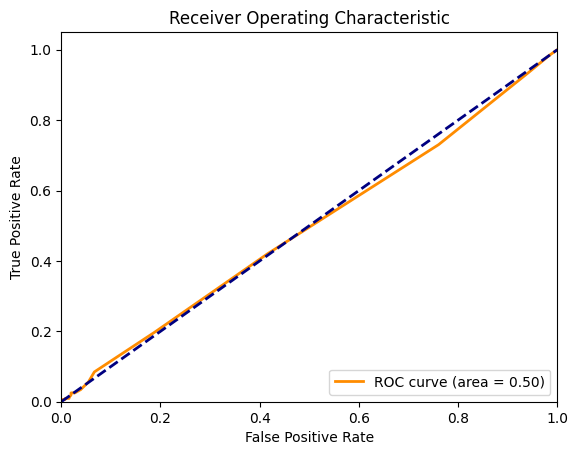

In [45]:
from transformers import pipeline
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Preparar una pipeline para clasificación
nlp_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Procesar los textos (esto puede tomar tiempo dependiendo de la longitud de 'df')
results = nlp_pipeline(texts.tolist())

# Obtener la probabilidad de la clase positiva para cada texto
# Asumiendo que la clase positiva es la segunda que retorna el modelo
positive_class_probabilities = [result[1]['score'] for result in results]

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(labels, positive_class_probabilities)
roc_auc = auc(fpr, tpr)

# Dibujar la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [46]:
df= df.drop(['Error Flag'], axis=1)

# Añadir las predicciones al DataFrame
df['Error Flag Pred'] = predictions

# Renombrar la columna 'Error Flag Pred' a 'Error Flag'
df.rename(columns={'Error Flag Pred': 'Error Flag'}, inplace=True)

# Seleccionar y conservar únicamente las columnas deseadas
df_final = df[['Text ID', 'Error Flag', 'Error Sentence ID', 'Corrected Sentence']]

# Mostrar las primeras filas del DataFrame final para verificar
print(df_final.head())


    Text ID  Error Flag  Error Sentence ID  \
0  ms-val-0           0                  5   
1  ms-val-1           0                 -1   
2  ms-val-2           0                 24   
3  ms-val-3           0                  4   
4  ms-val-4           0                  0   

                                  Corrected Sentence  
0      Culture tests indicate Trichomonas vaginalis.  
1                                                NaN  
2  Pathology confirms Mycoplasma pneumoniae is th...  
3  Laboratory studies confirm that he has parainf...  
4  A previously healthy 25-year-old man comes to ...  


In [48]:
df_final['Error Flag'].value_counts()

0    574
Name: Error Flag, dtype: int64

In [49]:
df_final['formatted'] = df_final.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Asegurar un solo espacio entre palabras, incluso si hay múltiples espacios originalmente
df_final['formatted'] = df_final['formatted'].apply(lambda x: ' '.join(x.split()))

# Guardar el DataFrame modificado a un archivo de texto sin comillas y con un solo espacio
with open('prediction_longformer_base_4096.txt', 'w', encoding='utf-8') as file:
    for item in df_final['formatted']:
        file.write("%s\n" % item)

# Importar la función de descarga de archivos de Colab
from google.colab import files

# Descargar el archivo de texto a tu computadora
files.download('prediction_longformer_base_4096.txt')

<ipython-input-49-f95f66764bce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['formatted'] = df_final.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
<ipython-input-49-f95f66764bce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['formatted'] = df_final['formatted'].apply(lambda x: ' '.join(x.split()))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>